# 第9章 一般化線形モデルのベイズ推定



## 9.1 一般化線形モデル



### 9.1.2 GLMモジュール



リスト9.1: データセットの作成



In [1]:
import numpy as np

n = 30
beta0_true = 1
beta1_true = 2

x = np.linspace(-1, 1, n)
rng = np.random.default_rng(1)
err = np.random.normal(0, 0.5, size=n)
y = beta0_true + beta1_true * x + err 

data = {'x': x, 'y': y}

リスト9.2: データの散布図を表示



Text(0, 0.5, '$y$')

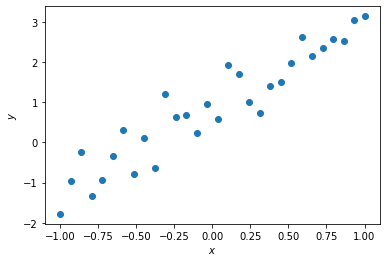

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(data['x'], data['y'])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

リスト9.3: `pm.GLM.from_formula` 関数の例



In [3]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    
    trace = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


リスト9.4: `family` 引数に指定できる確率分布の一覧



In [4]:
print([x for x in dir(pm.glm.families) if x[0].isupper()])

['Binomial', 'Family', 'Identity', 'NegativeBinomial', 'Normal', 'Poisson', 'StudentT']


リスト9.5: `priors` 引数と `familiy` 引数の指定方法の例



In [5]:
with pm.Model() as model:
    priors = {
        'Intercept': pm.Normal.dist(mu=0, sigma=100),
        'x': pm.Normal.dist(mu=0, sigma=100)
    }
    pm.GLM.from_formula('y ~ x', data,
                        priors=priors, 
                        family=pm.glm.families.Normal())
    
    trace = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


リスト9.6: トレースプロットを表示



array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

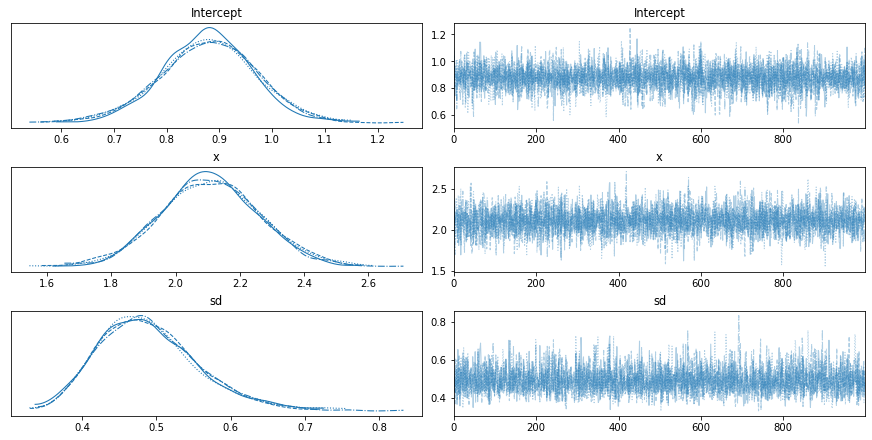

In [6]:
pm.plot_trace(trace)

リスト9.7: 要約統計量の確認



In [7]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.878,0.090,0.707,1.048,0.001,0.001,4867.0,2479.0,1.0
x,2.109,0.154,1.816,2.393,0.002,0.002,4290.0,2786.0,1.0
sd,0.490,0.067,0.371,0.616,0.001,0.001,3906.0,2981.0,1.0


リスト9.8: 回帰直線を描画



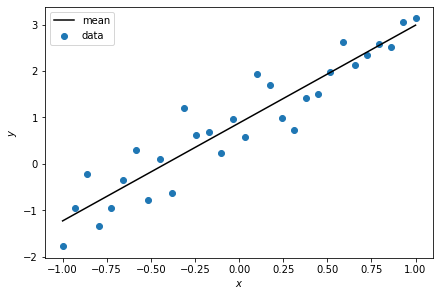

In [8]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'], label='data')
ax.plot(data['x'], trace['Intercept'].mean() + trace['x'].mean() * data['x'], 'k', label='mean')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

## 9.2 ロジスティック回帰



### 9.2.1 分類問題



リスト9.9: データセットの作成



In [9]:
import numpy as np

n = 30
x = np.zeros(n)
y = np.zeros(n, dtype=int)
# 分布の開始点
Dist_s = [2.4, 2.8]
# 分布の幅
Dist_w = [0.8, 1.6]

rng = np.random.default_rng(10)
for i in range(n):
    wk = rng.random()
    y[i] = 0 * (wk < 0.5) + 1 * (wk >= 0.5)
    x[i] = rng.random() * Dist_w[y[i]] + Dist_s[y[i]]

data = {'x': x, 'y': y}

リスト9.10: データの散布図を表示



Text(0, 0.5, '$y$')

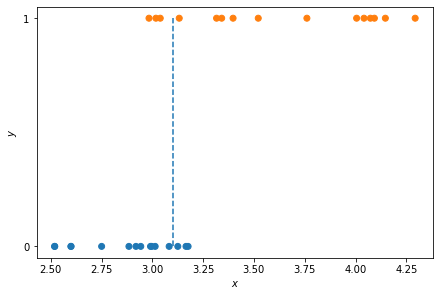

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'],
           color=[f'C{i}' for i in data['y']])
ax.vlines(x=3.1, ls='--', ymin=0, ymax=1)
ax.set_yticks([0, 1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

リスト9.11: 線形回帰モデルによるパラメータ推定



In [11]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

# データの中心化
data['x_c'] = data['x'] - data['x'].mean()

with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    epsilon = pm.HalfNormal('epsilon', sigma=5)    
    
    mu = pm.Deterministic('mu',
                          beta0 + beta1 * data['x_c'])
    boundary = pm.Deterministic('boundary',
                                (0.5 - beta0) / beta1)
    
    pm.Normal('y', mu=mu, sigma=epsilon, 
              observed=data['y'])
    
    trace = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


リスト9.12: 線形回帰モデルで推定した決定境界を描画



Text(0, 0.5, '$y$')

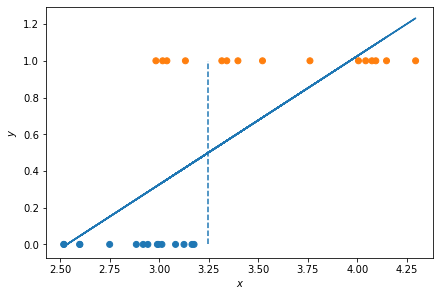

In [12]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'],
           color=[f'C{i}' for i in data['y']])
ax.plot(data['x'], trace['mu'].mean(axis=0))
ax.vlines(x=trace['boundary'].mean(axis=0) + data['x'].mean(), ls='--', ymin=0, ymax=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

### 9.2.2 ロジスティック関数



リスト9.13: ロジスティック関数の曲線①



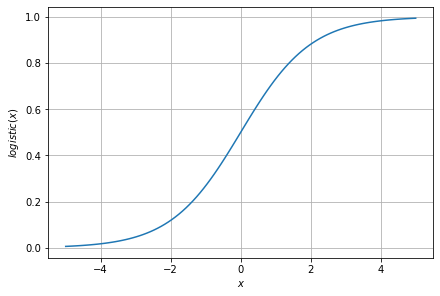

In [13]:
x = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(x, 1 / (1 + np.exp(-x)))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$logistic(x)$')
ax.grid()

リスト9.14: ロジスティック関数の曲線②



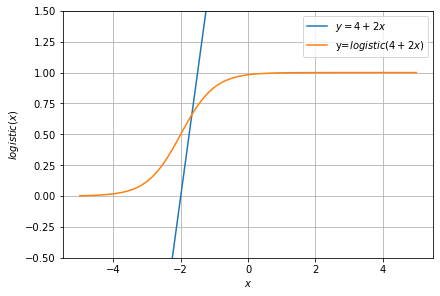

In [14]:
# ロジスティック関数を定義
def logistic(x, b):
    # パラメータは b 引数で指定する
    y = 1 / (1 + np.exp(-(b[0] + b[1] * x)))
    return y

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(x, 4 + 2 * x, label=r'$y=4+2x$')
ax.plot(x, logistic(x, [4, 2]), label=r'y=$logistic(4+2x)$')
ax.set_ylim([-0.5, 1.5])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$logistic(x)$')
ax.grid()
ax.legend()

### 9.2.3 ロジスティック回帰モデル



リスト9.15: ロジスティック回帰モデルによるパラメータ推定



In [15]:
with pm.Model() as model_l:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    
    mu = pm.Deterministic('mu', pm.math.sigmoid(beta0 + beta1 * data['x_c']))
    boundary = pm.Deterministic('boundary',
                                -beta0 / beta1)
    
    pm.Bernoulli('y', p=mu, observed=data['y'])
    
    trace_l = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
The number of effective samples is smaller than 25% for some parameters.


リスト9.16: トレースプロットを表示



array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>]], dtype=object)

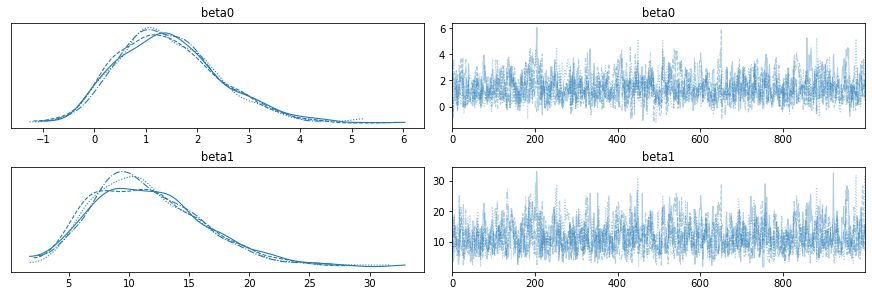

In [16]:
names = ['beta0', 'beta1']
pm.plot_trace(trace_l, var_names=names)

リスト9.17: 要約統計量の確認



In [17]:
pm.summary(trace_l, var_names=names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.446,0.982,-0.185,3.354,0.032,0.025,987.0,1098.0,1.0
beta1,11.691,4.712,3.485,20.067,0.155,0.114,1016.0,1261.0,1.0


リスト9.18: 成功確率に対する対数オッズの変化



Text(0, 0.5, 'log-odds')

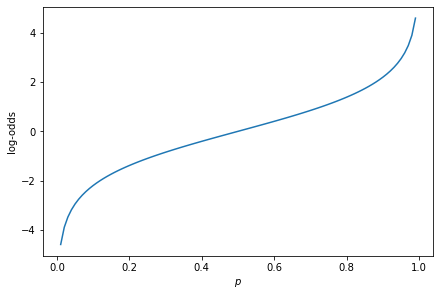

In [19]:
p = np.linspace(0.01, 0.99, 100)
odds = np.log(p / (1 - p))

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(p, odds)

ax.set_xlabel(r'$p$')
ax.set_ylabel('log-odds')

リスト9.19: 推定されたシグモイド曲線と決定境界を描画



Text(0, 0.5, '$y$')

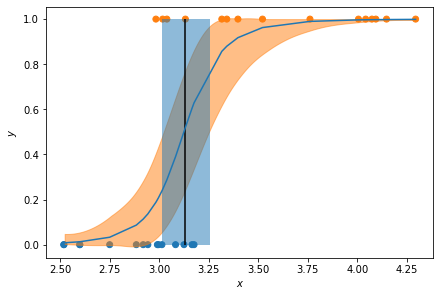

In [20]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'], color=[f'C{i}' for i in data['y']])

# 推定されたシグモイド曲線の描画
mu = trace_l['mu'].mean(axis=0)
idx = np.argsort(data['x'])
ax.plot(data['x'][idx], mu[idx])
pm.plot_hdi(data['x'], trace_l['mu'], ax=ax)

# 決定境界の描画
plt.vlines(trace_l['boundary'].mean(axis=0) + data['x'].mean(), 0, 1, color='k')
boundary_hdi = pm.hdi(trace_l['boundary']) + data['x'].mean()
ax.fill_betweenx([0, 1] , boundary_hdi[0],
                 boundary_hdi[1], alpha=0.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

### 9.2.4 ロバストロジスティック回帰



リスト9.20: 外れ値を加えたデータセットの作成



Text(0, 0.5, '$y$')

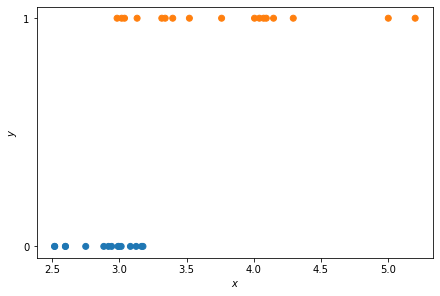

In [21]:
data['x2'] = np.append(data['x'], [5.0, 5.2])
data['y2'] = np.append(data['y'], [1, 1])
data['x2_c'] = data['x2'] - data['x2'].mean()

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x2'], data['y2'],
           color=[f'C{i}' for i in data['y2']])
ax.set_yticks([0, 1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

リスト9.21: パラメータ $\psi$ の曲線に対する影響



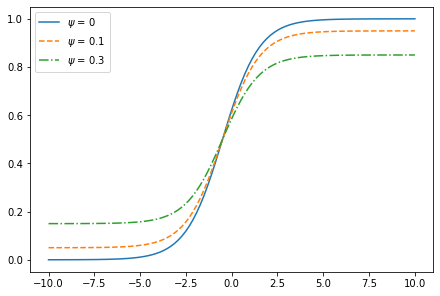

In [22]:
fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(-10, 10, 100)

psis = [0, 0.1, 0.3]
ls = ['-', '--', '-.']

for psi, l in zip(psis, ls):
    p = 0.5 * psi + (1 - psi) * logistic(x, [0.5, 1])
    ax.plot(x, p, l, label=f'$\psi$ = {psi}')

ax.legend()

リスト9.22: ベータ分布におけるパラメータ $\alpha, \beta$ の影響



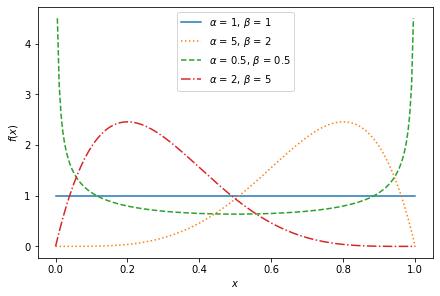

In [23]:
from scipy import stats

x = np.linspace(0, 1, 200)
alphas = [1, 5, 0.5, 2]
betas = [1, 2, 0.5, 5]
ls = ['-', ':', '--', '-.']

fig, ax = plt.subplots(constrained_layout=True)

for alpha, beta, l in zip(alphas, betas, ls):
    pdf = stats.beta.pdf(x, alpha, beta)
    ax.plot(x, pdf, l, label=rf'$\alpha$ = {alpha}, $\beta$ = {beta}')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()

リスト9.23: ロバストなロジスティック回帰モデルによるパラメータ推定



In [24]:
with pm.Model() as model_rl:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    psi = pm.Beta('psi', 1, 1)
    
    mu = pm.Deterministic('mu', pm.math.sigmoid(beta0 + beta1 * data['x2_c']))
    p = psi * 0.5 + (1 - psi) * mu
    boundary = pm.Deterministic('boundary',
                                -beta0 / beta1)
    
    pm.Bernoulli('y', p=p, observed=data['y2'])
    
    trace_rl = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


リスト9.24: トレースプロットの表示



array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'psi'}>,
        <AxesSubplot:title={'center':'psi'}>]], dtype=object)

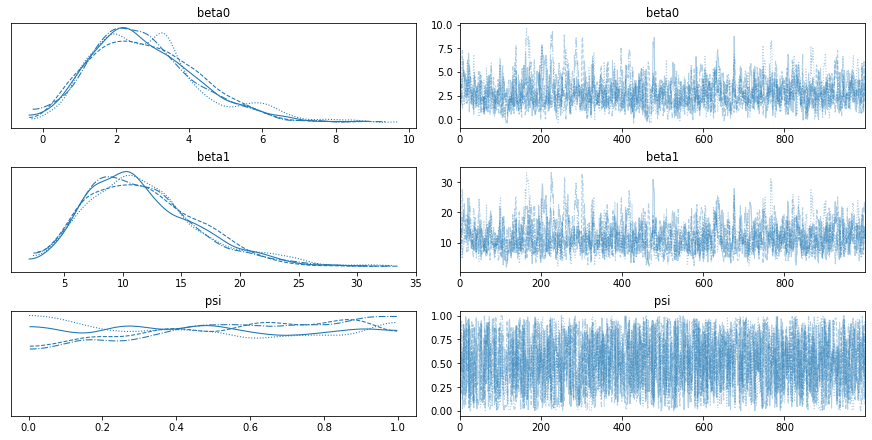

In [25]:
names = ['beta0', 'beta1', 'psi']
pm.plot_trace(trace_rl, var_names=names)

リスト9.25: 要約統計量の確認



In [26]:
pm.summary(trace_rl, var_names=names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,2.831,1.518,0.263,5.759,0.049,0.037,1019.0,1129.0,1.0
beta1,11.779,4.883,4.023,21.385,0.158,0.118,1022.0,1080.0,1.0
psi,0.510,0.288,0.045,0.975,0.007,0.005,1779.0,1625.0,1.0


リスト9.26: 推定されたシグモイド曲線と決定境界を描画



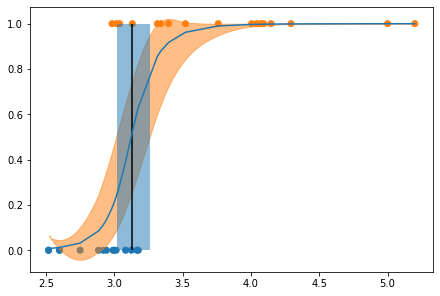

In [27]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x2'], data['y2'],
           color=[f'C{i}' for i in data['y2']])

mu = trace_rl['mu'].mean(axis=0)
idx = np.argsort(data['x2'])
ax.plot(data['x2'][idx], mu[idx])

pm.plot_hdi(data['x2'], trace_rl['mu'], ax=ax)

plt.vlines(trace_rl['boundary'].mean() + data['x2'].mean(), 0, 1, color='k')
boundary_hdi = pm.hdi(trace_rl['boundary']) + data['x2'].mean()
ax.fill_betweenx([0, 1], boundary_hdi[0], boundary_hdi[1], alpha=0.5)

## 9.3 ポアソン回帰



### 9.3.1 ポアソン回帰モデル



リスト9.27: データセットの作成



In [1]:
import numpy as np
import pandas as pd

n = 30
psi = 0.1 

rng = np.random.default_rng(123)
x1 = rng.random(n) * 30
x2 = rng.random(n) * 30
counts1 = np.array([(rng.random() > psi) * rng.poisson(0.1 + 0.15 * x1[i]) for i in range(n)])
counts2 = np.array([(rng.random() > psi) * rng.poisson(0.15 + 0.25 * x2[i]) for i in range(n)])
temp = np.concatenate([x1, x2])
obs = np.concatenate([counts1, counts2])
weather = np.concatenate([np.zeros(n, dtype=int),
                          np.ones(n, dtype=int)])
data = pd.DataFrame({'temp': temp, 'obs': obs, 
                     'weather': weather})

data.head()

,temp,obs,weather
0,20.470556,4,0
1,1.614631,0,0
2,6.610796,1,0
3,5.531154,1,0
4,5.277177,0,0


リスト9.28: 釣れた魚の数、気温、天気の散布図



<AxesSubplot:xlabel='temp', ylabel='obs'>

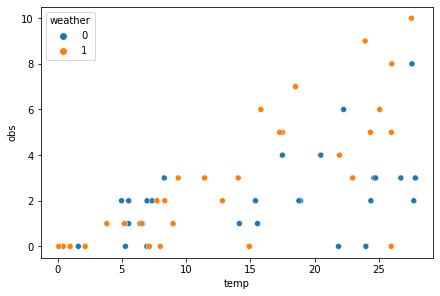

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(constrained_layout=True)

sns.scatterplot(data=data, x='temp', y='obs',
                hue='weather', ax=ax)

リスト9.29: ポアソン回帰モデルのパラメータ推定



In [3]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

with pm.Model() as model_p:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    beta2 = pm.Normal('beta2', mu=0, sigma=100)
    
    lambda_ = pm.math.exp(beta0 + beta1 * data['temp'] + beta2 * data['weather'])
    
    pm.Poisson('y', lambda_, observed=data['obs'])
    
    trace_p = pm.sample(random_seed=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The acceptance probability does not match the target. It is 0.8825919615439796, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


リスト9.30: トレースプロットを表示



array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>]], dtype=object)

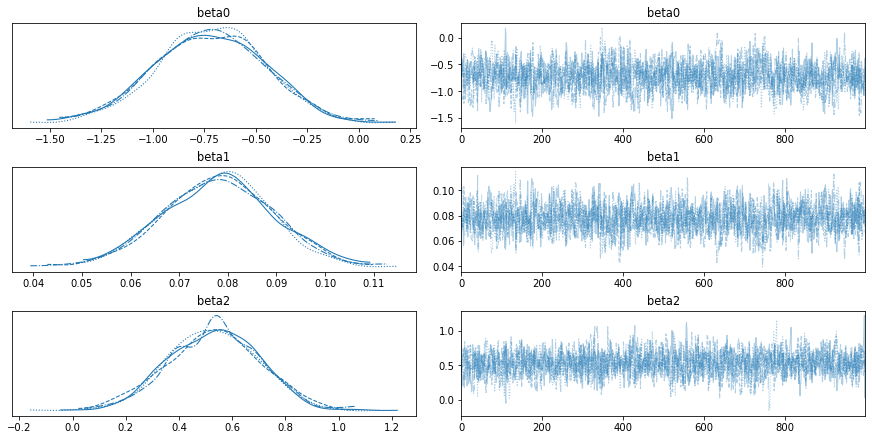

In [4]:
pm.plot_trace(trace_p)

リスト9.31: 要約統計量の確認



In [5]:
pm.summary(trace_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.720,0.264,-1.187,-0.198,0.009,0.006,936.0,1001.0,1.0
beta1,0.078,0.011,0.058,0.099,0.000,0.000,961.0,1097.0,1.0
beta2,0.532,0.172,0.232,0.873,0.004,0.003,1604.0,1353.0,1.0


リスト9.32: 回帰曲線を描画



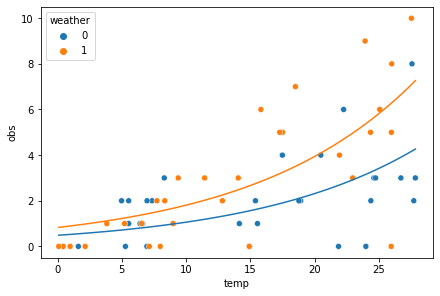

In [6]:
beta0_m = trace_p['beta0'].mean()
beta1_m = trace_p['beta1'].mean()
beta2_m = trace_p['beta2'].mean()
x = np.linspace(data['temp'].min(), 
                data['temp'].max(), 100)

fig, ax = plt.subplots(constrained_layout=True)

sns.scatterplot(data=data, x='temp', y='obs',
                hue='weather', ax=ax)

ax.plot(x, np.exp(beta0_m + beta1_m * x))
ax.plot(x, np.exp(beta0_m + beta1_m * x + beta2_m))

リスト9.33: 事後予測の乱数を生成



In [7]:
with model_p:
    pp = pm.sample_posterior_predictive(trace_p)

リスト9.34: 事後予測の $99\%$ HDI



<AxesSubplot:xlabel='temp', ylabel='obs'>

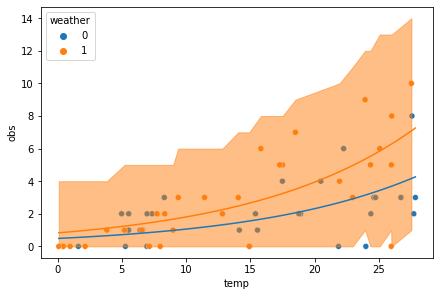

In [8]:
fig, ax = plt.subplots(constrained_layout=True)

sns.scatterplot(data=data, x='temp', y='obs',
                hue='weather', ax=ax)

ax.plot(x, np.exp(beta0_m + beta1_m * x))
ax.plot(x, np.exp(beta0_m + beta1_m * x + beta2_m))
pm.plot_hdi(data['temp'][30:], pp['y'][:, 30:],
            hdi_prob=0.99, smooth=False, ax=ax)

### 9.3.2 ゼロ過剰ポアソンモデル



リスト9.35: ゼロ過剰ポアソン分布におけるパラメータ $\psi, \lambda$ の影響



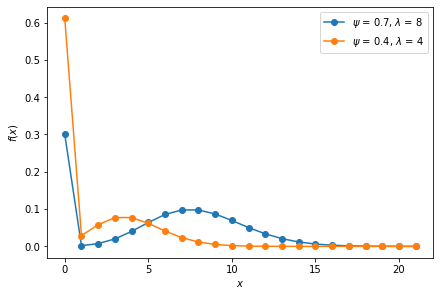

In [9]:
from scipy import stats

x = np.arange(0, 22)
psis = [0.7, 0.4]
lambdas = [8, 4]

fig, ax = plt.subplots(constrained_layout=True)

for psi, lam in zip(psis, lambdas):
    pmf = stats.poisson.pmf(x, lam)
    pmf[0] = (1 - psi) + pmf[0]
    pmf[1:] =  psi * pmf[1:]
    pmf /= pmf.sum()
    ax.plot(x, pmf, '-o',
            label=rf'$\psi$ = {psi}, $\lambda$ = {lam}')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()

リスト9.36: データセットの作成



In [10]:
n = 100
lambda_ = 3
psi = 0.6

rng = np.random.default_rng(1)
y = rng.random(n) > psi
Dist_0 = rng.poisson(lambda_, n)
Dist_1 = np.zeros(n, dtype=int)
counts = np.where(y, Dist_0, Dist_1)

counts

array([0, 3, 0, 3, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 2, 6, 1, 0, 0, 0, 2, 0, 0, 8, 1, 2, 2, 0, 0, 0, 0, 4, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 2, 3, 0, 4, 0, 0, 4, 1, 2, 0, 0, 0, 3, 3, 4, 0,
       0, 3, 4, 1, 0, 0, 3, 0, 0, 0, 4, 3, 5, 3, 3, 0, 3, 0, 3, 0, 6, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2], dtype=int64)

リスト9.37: ゼロ過剰ポアソンモデルのパラメータ推定



In [11]:
with pm.Model() as model_zip:
    psi = pm.Beta('psi', 1, 1)
    lambda_ = pm.Gamma('lambda', 2, 0.1)
    
    pm.ZeroInflatedPoisson('y', psi, lambda_,
                           observed=counts)
    
    trace_zip = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


リスト9.38: トレースプロットを表示



array([[<AxesSubplot:title={'center':'psi'}>,
        <AxesSubplot:title={'center':'psi'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>]], dtype=object)

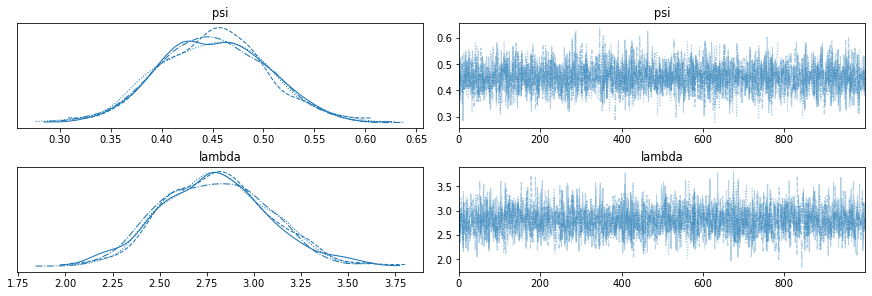

In [12]:
pm.plot_trace(trace_zip)

リスト9.39: 要約統計量を確認



In [13]:
pm.summary(trace_zip)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.451,0.053,0.353,0.548,0.001,0.001,3347.0,2776.0,1.0
lambda,2.799,0.284,2.304,3.356,0.005,0.004,3119.0,2602.0,1.0


リスト9.40: 事後予測の乱数を生成



In [15]:
with model_zip:
    pp = pm.sample_posterior_predictive(trace_zip, 100,
                                        random_seed=1)

リスト9.41: データと事後予測の比較



Text(0, 0.5, 'frequency')

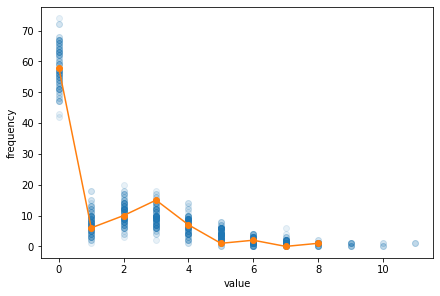

In [16]:
fig, ax = plt.subplots(constrained_layout=True)

for i in pp['y']:
    ax.plot(np.histogram(i, bins=i.max() + 1)[0],
            'oC0', alpha=0.1)

ax.plot(np.histogram(counts, bins=counts.max() + 1)[0],
        '-oC1')

ax.set_xlabel('value')
ax.set_ylabel('frequency')